In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.get_device_details(gpus[0])

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

{'compute_capability': (6, 1), 'device_name': 'NVIDIA GeForce GTX 1070'}

In [2]:
input_shape = (224, 224, 3)
image_shape = (224, 224)
num_classes = 5
batch_size = 8

train_data, val_data = keras.utils.image_dataset_from_directory('flower_images', batch_size=batch_size, image_size=image_shape, label_mode='categorical', seed=225, validation_split= 0.2, subset='both')

Found 4999 files belonging to 5 classes.
Using 4000 files for training.
Using 999 files for validation.


In [3]:
def resnet_block(filters, prev, index):
    x = keras.layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(prev)
    # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters=filters * 4, kernel_size=1, strides=1, padding='same')(x)
    # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x0 = keras.layers.Conv2D(filters=filters * 4, kernel_size=1, strides=1, padding='same')(x)
    # x0 = keras.layers.BatchNormalization()(x)
    
    
    if index == 0:
        x = keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1, padding='same')(prev)
        # x = keras.layers.BatchNormalization()(x)
        
        x = keras.layers.add([x, x0])
    
    else:
        x = keras.layers.add([prev, x])
    
    x = keras.layers.ReLU()(x)
    
    return x


In [4]:
input = keras.Input(shape=input_shape)

x = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(input)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

for i in range(3):
    x = resnet_block(64, x, i)

for i in range(4):
    x = resnet_block(128, x, i)
    
for i in range(6):
    x = resnet_block(256, x, i)
    
for i in range(3):
    x = resnet_block(512, x, i)

# Classifier
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
output = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

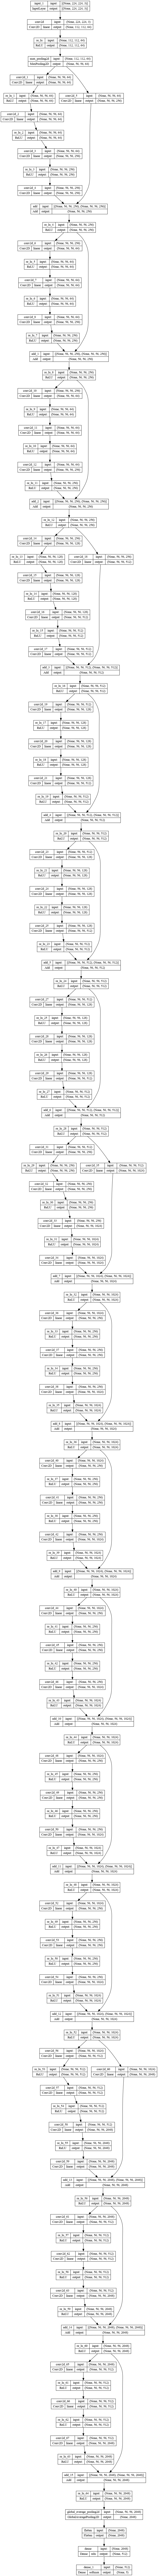

In [5]:
keras.utils.plot_model(model, to_file='model_architectures/resnet-50.png', expand_nested=True, show_layer_activations=True, show_shapes=True)

In [6]:
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr / 10
    else:
        return lr
    
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.LearningRateScheduler(lr_schedule), 
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/vgg16_bn.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [ ]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.01), 
    metrics='accuracy',
    )

history = model.fit(train_data, epochs=100, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose='auto')